In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline


Bad key text.latex.preview in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\

In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from quetzal.model import stepmodel
from quetzal.analysis import analysis
from quetzal.engine.pathfinder import PublicPathFinder
from quetzal.io.display import all_pt_paths
from syspy.skims import skims
from quetzal.io import excel

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the PT network
## Needs aggregated PT networks

In [3]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Create a path for scenario-specific model files
if not os.path.exists(model_path + scenario + '/'):
    os.makedirs(model_path + scenario + '/')

In [5]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [6]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
ae = stepmodel.read_json(model_path + 'de_pt_access_egress')
aux = stepmodel.read_json(model_path + 'de_pt_network_ancillary')

In [7]:
sm.centroids = ae.centroids
sm.footpaths = ae.footpaths
sm.zone_to_transit = ae.zone_to_transit

In [8]:
sm.links.shape

(280609, 10)

### Prepare links for pathfinder

Headways are relevant for the pathfinder in order to determine optimal interchange patterns. The waiting time (= half the headway) at the initial boarding station will be substracted from the route time. Instead, a constant "wait at station" time is added to access links. This does not depend on the itinerary, but only on travel behaviour and perception.

In [9]:
# aggregate local bus and tram, underground, ferry, funicular
if 'subway' in sm.links['route_type'].unique():
    sm.links['route_type_disagg'] = sm.links['route_type'].copy()
    sm.links['route_type'] = sm.links['route_type'].replace(
        {'tram': 'bus', 'subway': 'bus', 'ferry': 'bus', 'funicular': 'bus'})
    sm.pt_route_types = list(sm.links['route_type'].unique())

In [10]:
# Route types without headway
sm.links.loc[sm.links['headway'].isna()].groupby('route_type').agg({'a': 'count'})

,a
route_type,


In [11]:
sm.links['headway'] = sm.links['headway'].fillna(2*3600)

In [12]:
# Minimum headways of each route
sm.links['headway_route'] = sm.links['route_id'].map(
    sm.links.groupby('route_id').agg({'headway': 'min'}).to_dict()['headway'])

array([[<AxesSubplot:title={'center':'headway_route'}>,
        <AxesSubplot:title={'center':'headway'}>]], dtype=object)

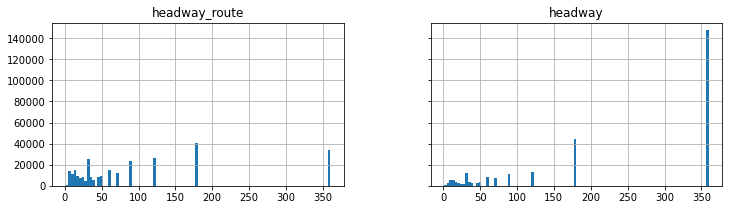

In [13]:
# Route headways seem to make route choice more reliable
(sm.links[['headway_route', 'headway']]/60/2).hist(bins=100, figsize=(12,3), sharey=True)

In [14]:
# Set a maximum headway in order to not confuse the pathfinder
urban_dict = sm.nodes['FID'].map(sm.zones['urbanisation'].to_dict()).to_dict()
for u in [1,2,3]:
    for mode in sm.pt_route_types:
        mask = (sm.links['route_type']==mode)&(sm.links['a'].map(urban_dict)==u)
        sm.links.loc[mask, 'headway'] = np.minimum(
            sm.links.loc[mask, 'headway_route'],
            params['max_headway_urban'+str(int(u))][mode])
#sm.links['headway'] = sm.links['headway_route']

In [15]:
sm.links['headway'] = sm.links['headway'].astype(int)

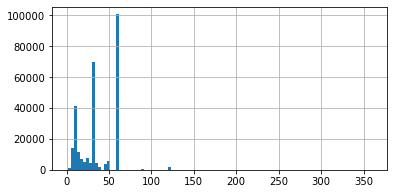

In [16]:
# Waiting time distribution in minutes
if manual: (sm.links['headway']/60/2).hist(bins=100, figsize=(6,3), log=False)

In [17]:
# Average waiting time
sm.links.groupby('route_type').agg({'headway': 'mean'})/60/2

,headway
route_type,
air,45.000000
bus,38.784922
coach,72.798834
rail_long,33.572058
rail_short,23.585941


In [18]:
# Set a mode-specific transfer penalty
# It will be substracted later
time_dict = params['transfer_penalty']
sm.links['boarding_time'] = sm.links['route_type'].map(time_dict) # in s

In [19]:
# Generate length for PT links
if 'length' not in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(sm.links['geometry']).astype(int)
    # Adjust coach transport towards road distances
    sm.links.loc[sm.links['route_type']=='coach', 'length'] *= 1.136

In [20]:
sm.links.sample()

,route_type,route_type_disagg,geometry,a,b,link_sequence,route_id,time,trip_id,headway,headway_route,boarding_time,length
index,,,,,,,,,,,,,
bus_99977,bus,bus,"LINESTRING (10.13875 54.30979, 10.13283 54.30987)",b_DEF02_60,b_DEF02_174,5,bus_10588,60,bus_10588_0,1200,1200,0,384.0


In [21]:
# Delete footpaths between centroids as they might confuse the pathfinder
# Add them later anew
sm.footpaths = sm.footpaths.loc[~((sm.footpaths['a'].isin(sm.centroids.index)) |
                                  (sm.footpaths['b'].isin(sm.centroids.index)) |
                                  (sm.footpaths['a']==sm.footpaths['b']))]

<AxesSubplot:>

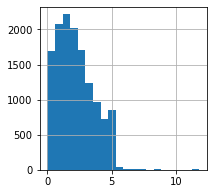

In [22]:
(sm.footpaths['time']/60).hist(bins=20, figsize=(3,3))

In [23]:
# Add a initial waiting time for PT access legs
sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access', 'time'] += \
    params['access-egress_links']['time_pt']

### Apply PT pathfinder
It generates the LoS table with shortest paths for each origin destination pair

In [24]:
# We don't want the algorithm to search paths for all mode combinations.
# Thus, we have to extract the pathfinder and search them manually.
ppf = PublicPathFinder(sm)

In [25]:
# Now, build custom mode combinations
# People just don't go by coach and then switch to rail or airplane within Germany
ppf.build_mode_combinations(mode_column='route_type')
#ppf.mode_combinations = [x for x in ppf.mode_combinations
#                         if not ('coach' in x and
#                         ('rail_long' in x or
#                          'rail_short' in x or
#                          'air' in x))]
ppf.mode_combinations

[{'air', 'bus', 'coach', 'rail_long', 'rail_short'},
 {'air', 'bus', 'coach', 'rail_long'},
 {'air', 'bus', 'coach', 'rail_short'},
 {'air', 'bus', 'coach'},
 {'air', 'bus', 'rail_long', 'rail_short'},
 {'air', 'bus', 'rail_long'},
 {'air', 'bus', 'rail_short'},
 {'air', 'bus'},
 {'air', 'coach', 'rail_long', 'rail_short'},
 {'air', 'coach', 'rail_long'},
 {'air', 'coach', 'rail_short'},
 {'air', 'coach'},
 {'air', 'rail_long', 'rail_short'},
 {'air', 'rail_long'},
 {'air', 'rail_short'},
 {'air'},
 {'bus', 'coach', 'rail_long', 'rail_short'},
 {'bus', 'coach', 'rail_long'},
 {'bus', 'coach', 'rail_short'},
 {'bus', 'coach'},
 {'bus', 'rail_long', 'rail_short'},
 {'bus', 'rail_long'},
 {'bus', 'rail_short'},
 {'bus'},
 {'coach', 'rail_long', 'rail_short'},
 {'coach', 'rail_long'},
 {'coach', 'rail_short'},
 {'coach'},
 {'rail_long', 'rail_short'},
 {'rail_long'},
 {'rail_short'},
 set()]

In [26]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + scenario + '/de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

Generated OD set with 160801 pairs


In [27]:
# Run the pathfinder for all mode combinations
# If there is no boarding time column in links table:
# Include a transfer penalty in order to promote direct routes.
# It will be substracted later
# The penalty must be None, if a link boarding time is set
transfer_penalty = None
ppf.find_broken_mode_paths(cutoff=np.inf,
                           od_set=od_set,
                           mode_column='route_type',
                           boarding_time=transfer_penalty)

breaking modes: set() : 100%|██████████████████████████████████████████████████████████| 32/32 [39:23<00:00, 73.87s/it]


In [28]:
# Run the path analysis and assign paths as LoS table
sm.pt_los = analysis.path_analysis_od_matrix(
    od_matrix=ppf.broken_mode_paths,
    links=sm.links,
    nodes=sm.nodes,
    centroids=sm.centroids)

path_analysis: 100%|███████████████████████████████████████████████████████| 4166510/4166510 [07:25<00:00, 9350.39it/s]


In [29]:
print(len(sm.pt_los.index))
sm.pt_los.loc[sm.pt_los['origin']!=sm.pt_los['destination']].sample()

4166510


,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,link_path,footpaths,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path
58965,DE407,DE126,30833.766632,"[DE407, rs_DE407_2, rs_1857, rs_1858, rs_1859,...",False,mode_breaker,"{rail_long, coach, bus}","[rs_DE407_2, rs_DED51_0, rs_DEG0N_0, rs_DE733_...","[rs_DED51_0, rs_DEG0N_0, rs_DE733_4, rs_DE712_...","[rs_DE407_2, rs_DED51_0, rs_DEG0N_0, rs_DE733_...","[rs_1857, rs_1858, rs_1859, rs_1860, rs_1861, ...",[],"[(DE407, rs_DE407_2), (rs_DE126_0, DE126)]","[rs_DED51_0, rs_DEG0N_0, rs_DE733_4, rs_DE712_0]","[rs_1857, rs_47541, rs_11390, rs_23662, rs_41276]","[rs_1861, rs_47572, rs_11399, rs_23672, rs_41276]",False,4,21240,487750.0


### Add attributes to LoS table

In [30]:
# Drop within-cell connections
sm.pt_los = sm.pt_los.loc[sm.pt_los['link_path'].apply(lambda l: len(l)>0)]
sm.pt_los.shape

(4153678, 20)

In [31]:
# Add distances (Only path, not access/egress)
len_dict = sm.links['length'].to_dict()
sm.pt_los['length'] = sm.pt_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [32]:
# Disaggregate time into in-vehicle and access/egress
# Substract the transfer penalty set above (put 0)
if transfer_penalty is None:
    sm.analysis_pt_time(boarding_time=None)
    sm.pt_los['time'] -= sm.pt_los['boarding_time']
#    sm.pt_los['boarding_time'] = 0
else:
    sm.analysis_pt_time(boarding_time=0)
sm.pt_los.columns

Index(['origin', 'destination', 'gtime', 'path', 'reversed',
       'pathfinder_session', 'broken_modes', 'boardings', 'alightings',
       'node_path', 'link_path', 'footpaths', 'ntlegs', 'transfers',
       'boarding_links', 'alighting_links', 'all_walk', 'ntransfers',
       'time_link_path', 'length_link_path', 'length', 'access_time',
       'footpath_time', 'in_vehicle_time', 'waiting_time', 'boarding_time',
       'time'],
      dtype='object')

In [33]:
# Substract the waiting time at the first stop
headway_dict = sm.links['headway'].to_dict()
mask = sm.pt_los['link_path'].apply(lambda l: l[0]).map(sm.links['route_type'].to_dict())!='air'
sm.pt_los.loc[mask, 'time'] -= sm.pt_los.loc[mask, 'link_path'].apply(
    lambda l: l[0]).map(headway_dict) / 2
sm.pt_los.loc[mask, 'waiting_time'] -= sm.pt_los.loc[mask, 'link_path'].apply(
    lambda l: l[0]).map(headway_dict) / 2

In [34]:
# Check times
sm.pt_los[['ntransfers', 'length']+[c for c in sm.pt_los.columns if c[-4:]=='time']].sample(2)

,ntransfers,length,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
66470,2,176161.0,13765.491755,1006.059543,129.432212,8580,3600.0,0,13315.491755
41178,1,491656.0,19416.078994,1356.078994,0.000000,14460,1800.0,0,17616.078994


In [35]:
# Add route_types
type_dict = sm.links['route_type'].to_dict()
sm.pt_los['route_types'] = [set([type_dict[link] for link in l])
                            for l in list(sm.pt_los['link_path'])]

In [36]:
# Add main route_type based on a hierarchy
hierarchy = ['air', 'coach', 'rail_long', 'rail_short', 'bus', 'walk']
def main_type(types):
    t = hierarchy[-1]
    try:
        t = hierarchy[min([hierarchy.index(t) for t in types])]
    except ValueError: # empty types set
        pass
    return t
sm.pt_los['route_type'] = sm.pt_los['route_types'].apply(main_type)

In [37]:
sm.pt_los.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,length_link_path,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_types,route_type
69771,DE71C,DEG0M,73962.389529,"[DE71C, b_DE71C_97, bus_500973, b_DE71C_153, b...",False,mode_breaker,"{rail_long, coach, rail_short}","[b_DE71C_97, b_DE71C_153, b_DE71B_41, b_DE71B_...","[b_DE71C_153, b_DE71B_41, b_DE71B_120, b_DE128...","[b_DE71C_97, b_DE71C_153, b_DE71B_41, b_DE71B_...",...,470840.0,470840.0,1814.889529,0.0,32980,38228.5,0,73023.389529,{bus},bus


In [38]:
# Make a safety copy before restricting results
if manual: los = sm.pt_los.copy()

In [39]:
#sm.pt_los = los.copy()

### Clean PT LOS

In [40]:
# Drop duplicates
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.pt_los.drop_duplicates('path', inplace=True)
sm.pt_los.reset_index(drop=True, inplace=True)
sm.pt_los.shape

(1922390, 29)

In [41]:
# Berlin - Hamburg
all_pt_paths(sm, 'DE300', 'DE600', verbose=False, group_name='route_type')

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.50it/s]


In [42]:
# Look at Berlin - Hamburg times
sm.pt_los.loc[(sm.pt_los['origin']=='DE300')&(sm.pt_los['destination']=='DE600')][
    ['ntransfers', 'length', 'route_types', 'link_path']+[c for c in sm.pt_los.columns if c[-4:]=='time']]

,ntransfers,length,route_types,link_path,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
56160,0,257678.000,{rail_short},"[rs_23000, rs_23001, rs_23002, rs_23003, rs_23...",11208.095910,1346.518569,21.577341,8040,0.0,0,9408.095910
171622,0,241407.000,{rail_long},[rl_1572],8731.195946,1351.195946,0.000000,5580,0.0,0,6931.195946
350687,0,281094.112,{coach},[c_2330],14851.536256,1291.536256,0.000000,11400,0.0,0,12691.536256
549996,0,241407.000,{rail_long},[rl_595],8731.195946,1351.195946,0.000000,5580,0.0,0,6931.195946
645680,23,498652.000,{bus},"[bus_1616909, bus_1616914, bus_1616916, bus_20...",75161.258137,1400.258137,0.000000,18570,54891.0,0,74861.258137
1535249,23,498652.000,{bus},"[bus_1616909, bus_1616914, bus_1616916, bus_20...",75161.258137,1400.258137,0.000000,18570,54891.0,0,74861.258137


In [43]:
# Drop trips with coach-rail or coach-air combinations
sm.pt_los = sm.pt_los.loc[~sm.pt_los['route_types'].apply(
    lambda x: 'coach' in x and ('rail_long' in x or 'rail_short' in x))]
sm.pt_los.shape

(1732657, 29)

In [44]:
'''# Drop trips with air interchange
sm.pt_los.drop(sm.pt_los.loc[(sm.pt_los['route_type']=='air') &
                             (sm.pt_los['link_path'].apply(
                                 lambda x: len([t for t in x if type_dict[t]=='air'])>1))
                            ].index, inplace=True)'''
sm.pt_los.shape

(1732657, 29)

In [45]:
# Drop unrealistically long trips
sm.pt_los = sm.pt_los.loc[sm.pt_los['in_vehicle_time']<params['clean_los']['max_duration']]
sm.pt_los.shape

(1605184, 29)

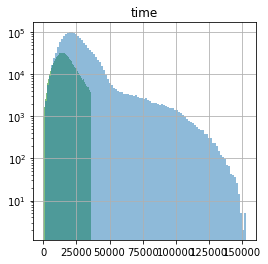

In [46]:
# Time distribution
if manual:
    sm.pt_los.hist(column='time', bins=100, log=True, alpha=.5,
                   ax=sm.pt_los.hist(column='in_vehicle_time', color='green',
                                     bins=100, figsize=(4,4), log=True, alpha=.5))

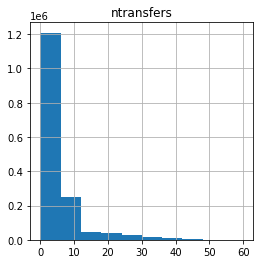

In [47]:
if manual: sm.pt_los.hist(column='ntransfers', figsize=(4,4))

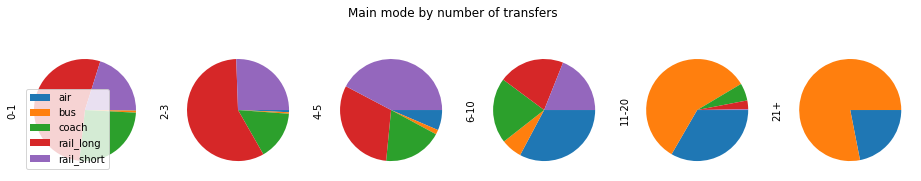

In [48]:
# Main mode distribution by transfers
if manual:
    t = sm.pt_los.copy()
    t['bins'] = pd.cut(t['ntransfers'], bins=[0,1,3,5,10,20,100],
                       labels=["0-1", "2-3","4-5","6-10","11-20","21+"])
    axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
        subplots=True, figsize=(16, 3),
        startangle=0, counterclock=False, title='Main mode by number of transfers',
        legend=False, labeldistance=None)
    axs[0].legend(loc='lower left')

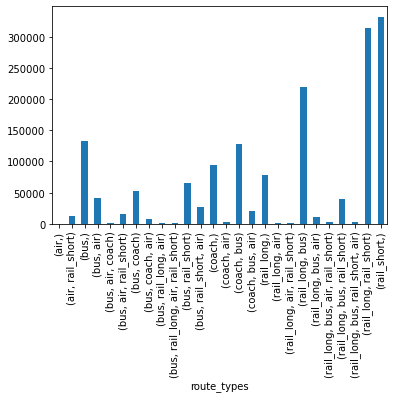

In [49]:
# Distribution of mode combinations
if manual:
    t['route_types'] = t['route_types'].apply(tuple)
    t.groupby('route_types').count()['route_type'].plot(kind='bar')

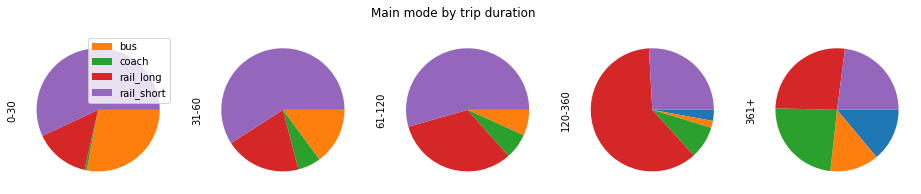

In [65]:
if manual:
    #t['time'] = t['time'] / 60
    t['bins'] = pd.cut(t['time'], bins=[0,30,60,120,360,5000],
                       labels=["0-30","31-60","61-120","120-360","361+"])
    axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
        subplots=True, figsize=(16, 3),
        startangle=0, counterclock=False, title='Main mode by trip duration',
        legend=False, labeldistance=None)
    axs[0].legend()

In [66]:
if manual: t = None

In [67]:
# Drop unnecessary long connections if there is a waiting time applied
if sm.links['headway'].mean() > 1*60:
    sm.pt_los = sm.pt_los.loc[sm.pt_los['ntransfers']<=
                              params['clean_los']['max_transfers']]
    # Drop coach connections with more than one transfer
    sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='coach') &
                                (sm.pt_los['boardings'].apply(
                                    lambda l: len([n for n in l if n.startswith('c')])>2)
                                ))]
sm.pt_los.shape

(1299396, 29)

In [68]:
# Keep only the fastest trip(s)
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple)
sm.pt_los = sm.pt_los.sort_values('time').groupby(
    ['origin', 'destination', 'route_types']).nth(
        list(range(params['clean_los']['n_fastest_trips']))).reset_index()
sm.pt_los.shape

(665853, 29)

In [69]:
# Bus tickets are relatively cheap, but they apply only for short distances
# And nobody books tickets at five different bus agencies
# Thus, drop bus trips longer than 100km
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='bus') &
                            (sm.pt_los['length']>params['clean_los']['max_dist_bus']))]
sm.pt_los.shape

(659365, 29)

In [70]:
# Also drop coach trips for local transport
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='coach') &
                            (sm.pt_los['length']<params['clean_los']['min_dist_coach']))]
sm.pt_los.shape

(658666, 29)

In [71]:
# Drop rail short-distance trips above a distance threshold,
# if a long-distance connection is available
sm.pt_los['both'] = sm.pt_los.merge(
    sm.pt_los.groupby(['origin', 'destination'])['route_type'].apply(
        lambda od: 'rail_short' in list(od) and 'rail_long' in list(od)).rename('both'),
    left_on=['origin', 'destination'], right_index=True)['both']
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='rail_short') &
                            (sm.pt_los['both']==True) &
                            (sm.pt_los['length']>params['clean_los']['max_dist_rail_short']))]
sm.pt_los.drop('both', axis=1, inplace=True)
sm.pt_los.shape

(557235, 29)

In [72]:
# Keep only trips where in-vehicle-time makes at least a third
#sm.pt_los = sm.pt_los.loc[sm.pt_los['time']<sm.pt_los['in_vehicle_time']*3]
#sm.pt_los.shape
len(sm.pt_los.loc[sm.pt_los['time']<sm.pt_los['in_vehicle_time']*3])

551193

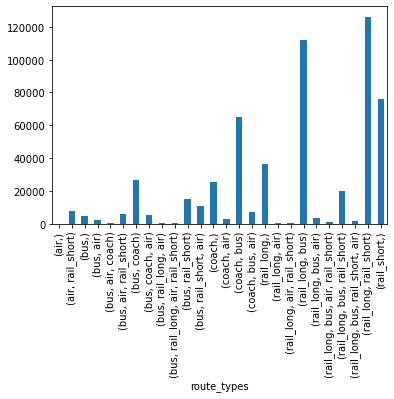

In [73]:
if manual: sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

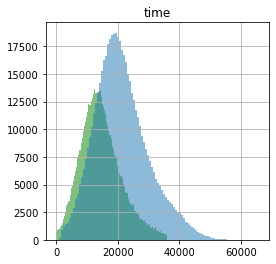

In [74]:
# Time distribution
if manual:
    sm.pt_los.hist(column='time', bins=100, log=False, alpha=.5,
                   ax=sm.pt_los.hist(column='in_vehicle_time', color='green',
                                     bins=100, figsize=(4,4), log=False, alpha=.5))

In [75]:
# Look at Berlin - Hamburg times
sm.pt_los.loc[(sm.pt_los['origin']=='DE300')&(sm.pt_los['destination']=='DE600')][
    ['ntransfers', 'length', 'route_types', 'link_path']+[c for c in sm.pt_los.columns if c[-4:]=='time']]

,ntransfers,length,route_types,link_path,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
236699,0,281094.112,"(coach,)",[c_2330],14851.536256,1291.536256,0.000000,11400,0.0,0,12691.536256
236700,0,241407.000,"(rail_long,)",[rl_595],8731.195946,1351.195946,0.000000,5580,0.0,0,6931.195946
236701,0,257678.000,"(rail_short,)","[rs_23000, rs_23001, rs_23002, rs_23003, rs_23...",11208.095910,1346.518569,21.577341,8040,0.0,0,9408.095910


In [76]:
# Stuttgart and surrounding?
sm.pt_los.loc[(sm.pt_los['origin']=='DE112')&(sm.pt_los['destination']=='DE111')]

,origin,destination,route_types,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,...,time_link_path,length_link_path,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_type
1661,DE112,DE111,"(bus,)",5722.238476,"(DE112, b_DE112_46, bus_1449393, b_DE112_16, b...",False,mode_breaker,"{rail_long, coach, air, rail_short}","[b_DE112_46, b_DE112_16, b_DE111_181]","[b_DE112_16, b_DE111_181, b_DE111_200]",...,240,15408.0,15408.0,1521.338695,60.899782,240,2100.0,0,3922.238476,bus
1662,DE112,DE111,"(rail_long,)",4509.558416,"(DE112, c_DE112_0, rl_DE112_0, rl_3455, rl_DE1...",False,mode_breaker,"{rail_short, bus, air, coach}",[rl_DE112_0],[rl_DE111_0],...,1260,16857.0,16857.0,1337.158194,112.400222,1260,0.0,0,2709.558416,rail_long
1663,DE112,DE111,"(rail_short,)",2567.558169,"(DE112, c_DE112_0, rs_DE112_1, rs_38554, rs_38...",False,mode_breaker,"{bus, air, coach}",[rs_DE112_1],[rs_DE111_11],...,540,9405.0,9405.0,1406.142235,221.415934,540,0.0,0,2167.558169,rail_short


In [77]:
print(len(sm.pt_los))
assert len(sm.pt_los.loc[sm.pt_los.isna().any(axis=1)])==0

557235


## Save model

In [78]:
# Ditch unneccessary columns
to_drop = ['gtime', 'path', 'reversed', 'pathfinder_session',
           'broken_modes', 'boardings', 'alightings', 'node_path',
           'footpaths', 'ntlegs', 'transfers', 'boarding_links',
           'alighting_links', 'all_walk', 'time_link_path',
           'length_link_path', 'boarding_time', 'index']
sm.pt_los = sm.pt_los.drop(to_drop, axis=1, errors='ignore')

In [79]:
# Clean links table
to_drop = ['duration', 'cost', 'origin', 'destination']
sm.links = sm.links.drop(to_drop, axis=1, errors='ignore')

In [80]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'footpath_time',
        'waiting_time', 'length']
sm.pt_los[cols] = sm.pt_los[cols].astype(int)

In [81]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,time,route_type
513975,DEB24,DEG0B,"(rail_long, bus)","[bus_1031279, bus_1031285, bus_x_63897, bus_x_...",4,389992,2251,331,16500,10800,29883,rail_long


In [82]:
# Saving LoS...
sm.to_json(model_path + scenario + '/' + 'de_pt_los',
           only_attributes=['pt_los'], encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:20<00:00,  1.68it/s]
